In [4]:
import json
import os
import numpy as np
import torch
from torchvision import models
import shap.benchmark as benchmark
import copy
import shap
import cv2
from explainer import GradientExplainer
import torchmetric
from appprior import compute_appearance_prior_all
from appprior import compute_appearance_prior_one
#通过数字找到对应的图片及其标签
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)
def find_image(label):
    path = "../data/imagenet50"
    files = os.listdir(path)
    #图片名为sim_n01549053_4208.jpg，所以取后面的数字
    for i in range(len(files)):
        num = int(files[i].split("_")[2].split(".")[0])
        class_num = files[i].split("_")[1].split(".")[0]
        class_name = class_names[class_num][1]
        if label == num:
            return path + "/" + files[i], class_name, class_num
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()
# load the model
model = models.vgg16(pretrained=True).eval().to(device)

X, y = shap.datasets.imagenet50()
print(X.shape)
print(y)

to_explain = np.concatenate((X[1:2],X[26:27]))
label = ["American_egret","bulbul"]
masker = shap.maskers.Image("inpaint_telea", X[0].shape)

(50, 224, 224, 3)
[6.3810e+03 1.6130e+03 7.2230e+03 7.2900e+03 7.4670e+03 8.1100e+02
 1.6028e+04 2.5680e+03 2.6251e+04 3.1050e+03 9.9540e+03 6.1170e+03
 2.2400e+03 3.9048e+04 9.3750e+03 6.2520e+03 7.8020e+03 1.4311e+04
 7.2780e+03 1.6148e+04 2.9190e+03 1.1105e+04 6.7670e+03 4.8980e+03
 3.7030e+03 1.4533e+04 4.2080e+03 5.6720e+03 9.5190e+03 7.2850e+03
 7.4270e+03 1.5667e+04 1.9730e+03 1.5199e+04 9.1830e+03 3.1090e+03
 2.4100e+03 8.1700e+03 1.0266e+04 2.6630e+03 7.1150e+03 3.5520e+03
 3.6620e+03 4.3860e+03 2.2866e+04 6.0770e+03 2.2100e+04 3.5310e+03
 1.3000e+01 2.0020e+03]


In [5]:
priors = []
for i in range(len(to_explain)):
    prior = compute_appearance_prior_one(to_explain[i],"vgg16",post=True)
    priors.append(prior)
print("先验信息类别：",len(priors))


postprior
features_of_interest: (3584, 7)


The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.


postprior
features_of_interest: (3584, 7)
先验信息类别： 2


samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1


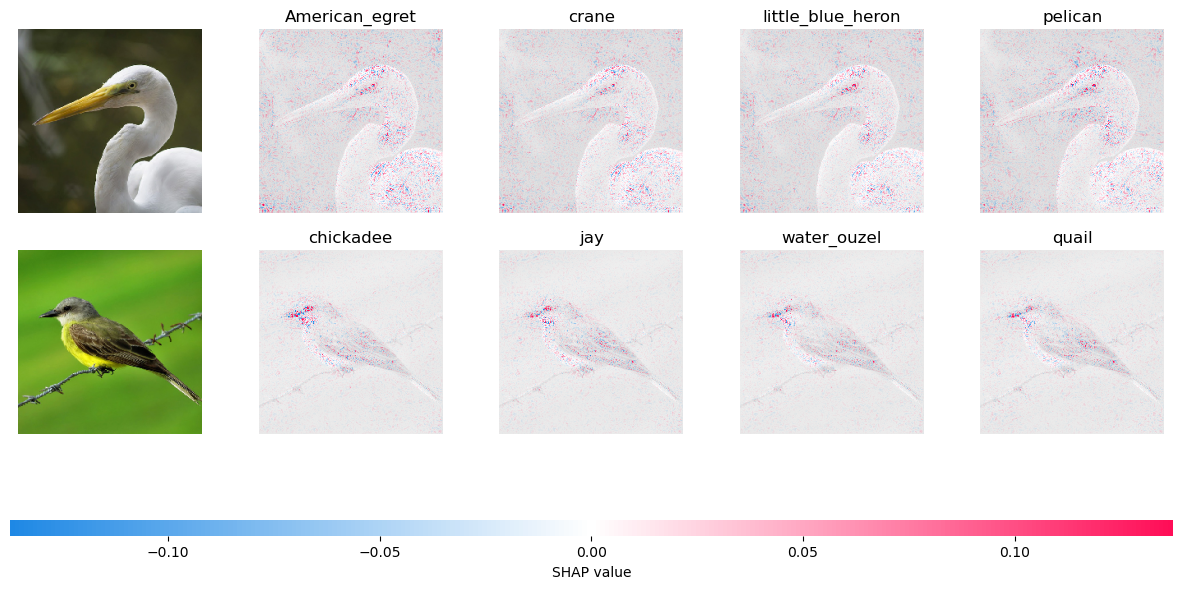

samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1
samples_input: torch.Size([200, 3, 224, 224])
samples_input_len: 1


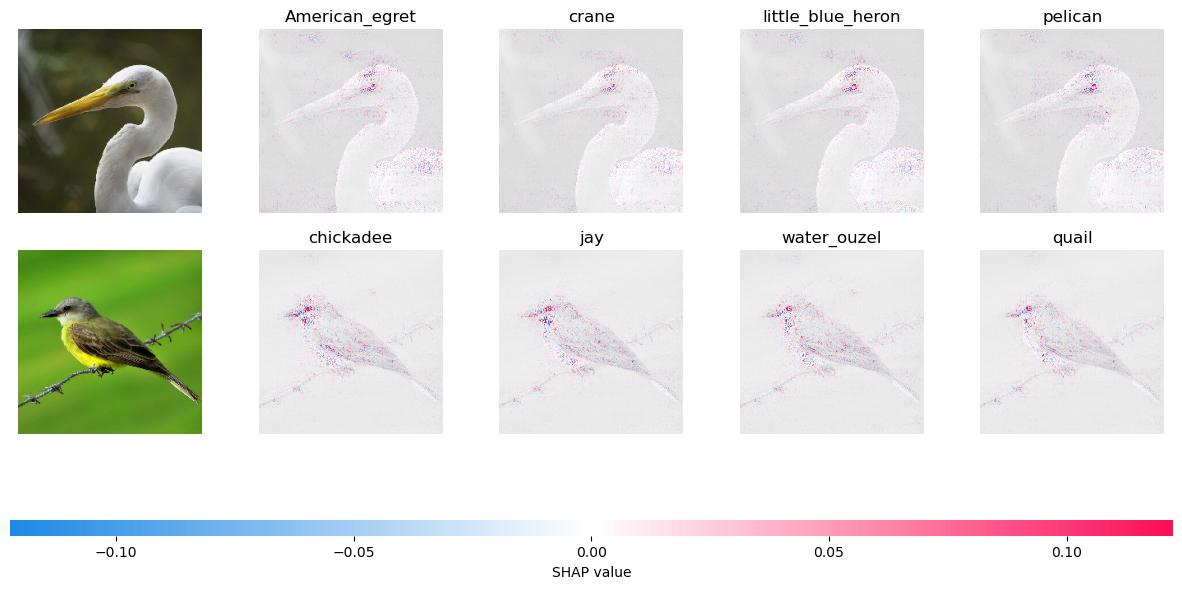

In [6]:
explainer = GradientExplainer(model=model,data=normalize(X).to(device) ,masker=masker, output_names=class_names)
shap_values_, indexes = explainer.shap_values(
    normalize(to_explain).to(device) ,ranked_outputs=4, nsamples=200, rseed =39
)
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values_]
# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes.cpu())
shap.image_plot(shap_values, to_explain, index_names)
shap_values_prior_, indexes = explainer.shap_values(
    normalize(to_explain).to(device) ,prior = priors,ranked_outputs=4, nsamples=200, rseed =39
)
shap_values_prior = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values_prior_]
index_names_prior = np.vectorize(lambda x: class_names[str(x)][1])(indexes.cpu())
shap.image_plot(shap_values_prior, to_explain, index_names_prior)

In [7]:
# shap_values = np.array(shap_values)
# shap_values = shap_values.transpose(1, 2, 3, 4, 0)
# shap_values_prior = np.array(shap_values_prior)
# shap_values_prior = shap_values_prior.transpose(1, 2, 3, 4, 0)

In [8]:
# sort_order = "positive"
# perturbation = "keep"
# sequential_perturbation = torchmetric3.SequentialPerturbation(
#     explainer.model, explainer.masker, sort_order, perturbation
# )
# # xs, ys, auc = sequential_perturbation.score(
# #     shap_values, to_explain
# # )
# # sequential_perturbation.plot(xs, ys, auc)
# xs, ys, auc = sequential_perturbation.score(
#     shap_values_prior, to_explain
# )
# sequential_perturbation.plot(xs, ys, auc)

In [9]:
# sort_order = "positive"
# perturbation = "remove"
# sequential_perturbation = torchmetric3.SequentialPerturbation(
#     explainer.model, explainer.masker, sort_order, perturbation
# )
# # xs, ys, auc = sequential_perturbation.score(
# #     shap_values, to_explain
# # )
# # sequential_perturbation.plot(xs, ys, auc)
# xs, ys, auc = sequential_perturbation.score(
#     shap_values_prior, to_explain
# )
# sequential_perturbation.plot(xs, ys, auc)

In [10]:

# sort_order = "negative"
# perturbation = "remove"
# sequential_perturbation = torchmetric3.SequentialPerturbation(
#     explainer.model, explainer.masker, sort_order, perturbation
# )
# # xs, ys, auc = sequential_perturbation.score(
# #     shap_values, to_explain
# # )
# # sequential_perturbation.plot(xs, ys, auc)
# xs, ys, auc = sequential_perturbation.score(
#     shap_values_prior, to_explain
# )
# sequential_perturbation.plot(xs, ys, auc)

In [11]:

# sort_order = "negative"
# perturbation = "keep"
# sequential_perturbation = torchmetric3.SequentialPerturbation(
#     explainer.model, explainer.masker, sort_order, perturbation
# )
# # xs, ys, auc = sequential_perturbation.score(
# #     shap_values, to_explain
# # )
# # sequential_perturbation.plot(xs, ys, auc)
# xs, ys, auc = sequential_perturbation.score(
#     shap_values_prior, to_explain
# )
# sequential_perturbation.plot(xs, ys, auc)

In [12]:

# sort_order = "absolute"
# perturbation = "keep"
# sequential_perturbation = torchmetric3.SequentialPerturbation(
#     explainer.model, explainer.masker, sort_order, perturbation
# )
# # xs, ys, auc = sequential_perturbation.score(
# #     shap_values, to_explain
# # )
# # sequential_perturbation.plot(xs, ys, auc)
# xs, ys, auc = sequential_perturbation.score(
#     shap_values_prior, to_explain
# )
# sequential_perturbation.plot(xs, ys, auc)

In [13]:

# sort_order = "absolute"
# perturbation = "remove"
# sequential_perturbation = torchmetric3.SequentialPerturbation(
#     explainer.model, explainer.masker, sort_order, perturbation
# )
# # xs, ys, auc = sequential_perturbation.score(
# #     shap_values, to_explain
# # )
# # sequential_perturbation.plot(xs, ys, auc)
# xs, ys, auc = sequential_perturbation.score(
#     shap_values_prior, to_explain
# )
# sequential_perturbation.plot(xs, ys, auc)